<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Probabilistic/Bijectors/RealNVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Assignment

## RealNVP for the LSUN bedroom dataset

### Instructions

In this notebook, you will develop the RealNVP normalising flow architecture from scratch, including the affine coupling layers, checkerboard and channel-wise masking, and combining into a multiscale architecture. You will train the normalising flow on a subset of the LSUN bedroom dataset.

Some code cells are provided for you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line:

`#### GRADED CELL ####`

Don't move or edit this first line - this is what the automatic grader looks for to recognise graded cells. These cells require you to write your own code to complete them, and are automatically graded when you submit the notebook. Don't edit the function name or signature provided in these cells, otherwise the automatic grader might not function properly.

### How to submit

Complete all the tasks you are asked for in the worksheet. When you have finished and are happy with your code, press the **Submit Assignment** button at the top of this notebook.

### Let's get started!

We'll start running some imports, and loading the dataset. Do not edit the existing imports in the following cell. If you would like to make further Tensorflow imports, you should add them here.

In [ ]:
!pip uninstall -y tensorflow tensorflow-probability

In [ ]:
!pip install tensorflow==2.12.0 tensorflow-probability==0.19.0

In [1]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

tfd = tfp.distributions
tfb = tfp.bijectors

# If you would like to make further imports from tensorflow, add them here

tf.__version__, tfp.__version__

('2.12.0', '0.19.0')

<table><tr>
<td> <img src="https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow/Probabilistic/Bijectors/figures/bedroom1.jpg?raw=1" alt="bedroom 1" style="height: 210px;"/>  </td>
<td> <img src="https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow/Probabilistic/Bijectors/figures/bedroom2.jpg?raw=1" alt="bedroom 2" style="height: 210px;"/> </td>
    <td> <img src="https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow/Probabilistic/Bijectors/figures/bedroom3.jpg?raw=1" alt="bedroom 3" style="height: 210px;"/> </td>
</tr></table>
  
#### The LSUN Bedroom Dataset

In this assignment, you will use a subset of the [LSUN dataset](https://www.yf.io/p/lsun). This is a large-scale image dataset with 10 scene and 20 object categories. A subset of the LSUN bedroom dataset has been provided, and has already been downsampled and preprocessed into smaller, fixed-size images.

* F. Yu, A. Seff, Y. Zhang, S. Song, T. Funkhouser and J. Xia. "LSUN: Construction of a Large-scale Image Dataset using Deep Learning with Humans in the Loop". [arXiv:1506.03365](https://arxiv.org/abs/1506.03365), 10 Jun 2015

Your goal is to develop the RealNVP normalising flow architecture using bijector subclassing, and use it to train a generative model of the LSUN bedroom data subset. For full details on the RealNVP model, refer to the original paper:

* L. Dinh, J. Sohl-Dickstein and S. Bengio. "Density estimation using Real NVP". [arXiv:1605.08803](https://arxiv.org/abs/1605.08803), 27 Feb 2017.

#### Load the dataset

The following functions will be useful for loading and preprocessing the dataset. The subset you will use for this assignment consists of 10,000 training images, 1000 validation images and 1000 test images.

The images have been downsampled to 32 x 32 x 3 in order to simplify the training process.

In [2]:
# Functions for loading and preprocessing the images

def load_image(img):
    img = tf.image.random_flip_left_right(image=img)
    return img, img

def load_dataset(split):
    train_list_ds = tf.data.Dataset.from_tensor_slices(
        tensors=np.load(file='./data/{}.npy'.format(split)))
    train_ds = train_list_ds.map(map_func=load_image)
    return train_ds

In [3]:
# Load the training, validation and testing datasets splits

train_ds = load_dataset('train')
val_ds = load_dataset('val')
test_ds = load_dataset('test')

In [4]:
# Shuffle the datasets

shuffle_buffer_size = 1000
train_ds = train_ds.shuffle(buffer_size=shuffle_buffer_size)
val_ds = val_ds.shuffle(buffer_size=shuffle_buffer_size)
test_ds = test_ds.shuffle(buffer_size=shuffle_buffer_size)

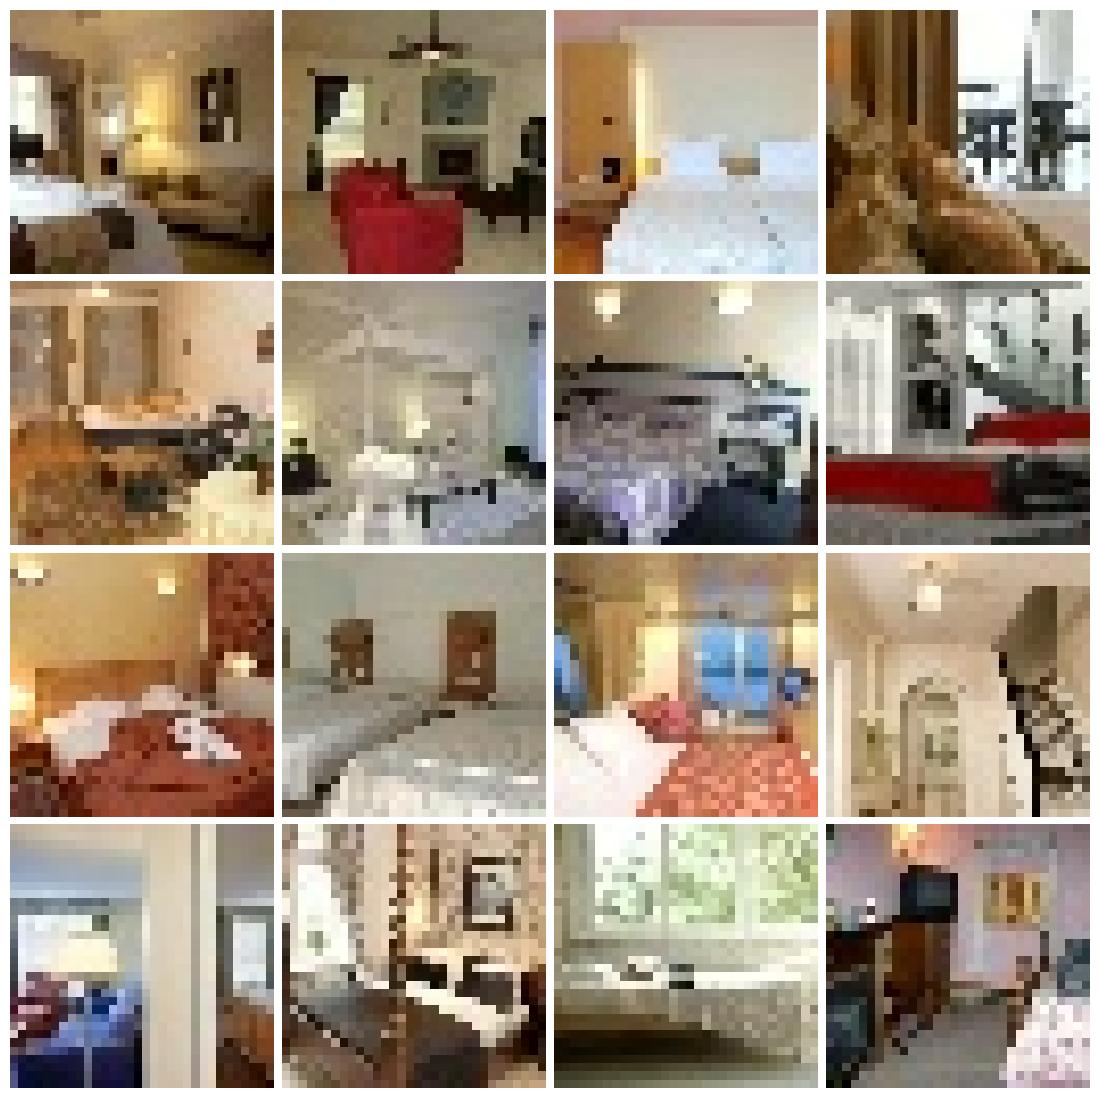

In [5]:
# Display a few examples

n_img = 4
f, axs = plt.subplots(nrows=n_img, ncols=n_img, figsize=(14, 14))

for k, image in enumerate(train_ds.take(count=n_img**2)):
    i = k // n_img
    j = k % n_img
    axs[i, j].imshow(X=image[0])
    axs[i, j].axis('off')
f.subplots_adjust(wspace=0.01, hspace=0.03)

In [6]:
# Batch the Dataset objects

batch_size = 64
train_ds = train_ds.batch(batch_size=batch_size)
val_ds = val_ds.batch(batch_size=batch_size)
test_ds = test_ds.batch(batch_size=batch_size)

### Affine coupling layer

We will begin the development of the RealNVP architecture with the core bijector that is called the _affine coupling layer_. This bijector can be described as follows: suppose that $x$ is a $D$-dimensional input, and let $d<D$. Then the output $y$ of the affine coupling layer is given by the following equations:

$$
\begin{align}
y_{1:d} &= x_{1:d} \tag{1}\\
    y_{d+1:D} &= x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d}), \tag{2}
\end{align}
$$

where $s$ and $t$ are functions from $\mathbb{R}^d\rightarrow\mathbb{R}^{D-d}$, and define the log-scale and shift operations on the vector $x_{d+1:D}$ respectively.

The log of the Jacobian determinant for this layer is given by $\sum_{j}s(x_{1:d})_j$.

The inverse operation can be easily computed as

$$
\begin{align}
x_{1:d} &= y_{1:d}\tag{3}\\
x_{d+1:D} &= \left(y_{d+1:D} - t(y_{1:d})\right)\odot \exp(-s(y_{1:d})),\tag{4}
\end{align}
$$

In practice, we will implement equations $(1)$ and $(2)$ using a binary mask $b$:

$$
\begin{align}
\text{Forward pass:}\qquad y &= b\odot x + (1-b)\odot\left(x\odot\exp(s(b\odot x)) + t(b\odot x)\right),\tag{5}\\
\text{Inverse pass:}\qquad x &= b\odot y + (1-b)\odot\left(y - t(b\odot y)) \odot\exp( -s(b\odot y)\right).\tag{6}
\end{align}
$$

Our inputs $x$ will be a batch of 3-dimensional Tensors with `height`, `width` and `channels` dimensions. As in the original architecture, we will use both spatial 'checkerboard' masks and channel-wise masks:

![Checkerboard and binary masks](https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow/Probabilistic/Bijectors/figures/binary_masks.png?raw=1)

<center>Figure 1. Spatial checkerboard mask (left) and channel-wise mask (right). From the original paper.</center>

#### Custom model for log-scale and shift

You should now create a custom model for the shift and log-scale parameters that are used in the affine coupling layer bijector. We will use a convolutional residual network, with two residual blocks and a final convolutional layer. Using the functional API, build the model according to the following specifications:

* The function takes the `input_shape` and `filters` as arguments
* The model should use the `input_shape` in the function argument to set the shape in the Input layer (call this layer `h0`).
* The first hidden layer should be a Conv2D layer with number of filters set by the `filters` argument, and a ReLU activation
* The second hidden layer should be a BatchNormalization layer
* The third hidden layer should be a Conv2D layer with the same number of filters as the input `h0` to the model, and a ReLU activation
* The fourth hidden layer should be a BatchNormalization layer
* The fifth hidden layer should be the sum of the fourth hidden layer output and the inputs `h0`. Call this layer `h1`
* The sixth hidden layer should be a Conv2D layer with filters set by the `filters` argument, and a ReLU activation
* The seventh hidden layer should be a BatchNormalization layer
* The eighth hidden layer should be a Conv2D layer with the same number of filters as `h1` (and `h0`), and a ReLU activation
* The ninth hidden layer should be a BatchNormalization layer
* The tenth hidden layer should be the sum of the ninth hidden layer output and `h1`
* The eleventh hidden layer should be a Conv2D layer with the number of filters equal to twice the number of channels of the model input, and a linear activation. Call this layer `h2`
* The twelfth hidden layer should split `h2` into two equal-sized Tensors along the final channel axis. These two Tensors are the shift and log-scale Tensors, and should each have the same shape as the model input
* The final layer should then apply the `tanh` nonlinearity to the log_scale Tensor. The outputs to the model should then be the list of Tensors `[shift, log_scale]`

All Conv2D layers should use a 3x3 kernel size, `"SAME"` padding and an $l2$ kernel regularizer with regularisation coefficient of `5e-5`.

_Hint: use_ `tf.split` _with arguments_ `num_or_size_splits=2, axis=-1` _to create the output Tensors_.

In total, the network should have 14 layers (including the `Input` layer).

In [7]:
#### GRADED CELL ####

# Complete the following function.
# Make sure to not change the function name or arguments.

def get_conv_resnet(input_shape, filters):
    """
    This function should build a CNN ResNet model according to the above specification,
    using the functional API. The function takes input_shape as an argument, which should be
    used to specify the shape in the Input layer, as well as a filters argument, which
    should be used to specify the number of filters in (some of) the convolutional layers.
    Your function should return the model.
    """

    h0 = Input(shape=input_shape)

    r = Conv2D(filters=filters, kernel_size=(3, 3), padding='SAME',
        activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.l2(l=5e-5))(inputs=h0)
    r = BatchNormalization()(inputs=r)
    r = Conv2D(filters=input_shape[-1], kernel_size=(3, 3),
        padding='SAME', activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.l2(l=5e-5))(inputs=r)
    r = BatchNormalization()(inputs=r)
    h1 = tf.math.add(x=h0, y=r)

    r = Conv2D(filters=filters, kernel_size=(3, 3), padding='SAME',
        activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.l2(l=5e-5))(inputs=h1)
    r = BatchNormalization()(inputs=r)
    r = Conv2D(filters=input_shape[-1], kernel_size=(3, 3),
        padding='SAME', activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.l2(l=5e-5))(inputs=r)
    r = BatchNormalization()(inputs=r)
    r = tf.math.add(x=h1, y=r)

    h2 = Conv2D(filters=2*input_shape[-1], kernel_size=(3, 3),
        padding='SAME', activation=tf.keras.activations.linear,
        kernel_regularizer=tf.keras.regularizers.l2(l=5e-5))(inputs=r)

    shift, log_scale = tf.split(value=h2, num_or_size_splits=2, axis=-1)
    log_scale = tf.math.tanh(log_scale)

    return Model(inputs=h0, outputs=[shift, log_scale])

In [8]:
# Test your function and print the model summary

conv_resnet = get_conv_resnet(input_shape=(32, 32, 3), filters=32)
conv_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 3)    867         ['batch_normalization[0][0]']

You can also inspect your model architecture graphically by running the following cell. It should look something like the following:

![ResNet plot](https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow/Probabilistic/Bijectors/figures/model_plot.png?raw=1)

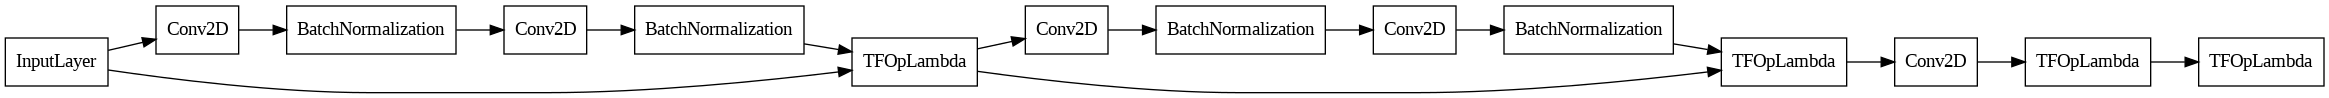

In [9]:
# Plot the model graph

tf.keras.utils.plot_model(conv_resnet, show_layer_names=False,
    rankdir='LR')

In [10]:
# Check the output shapes are as expected

print(conv_resnet(inputs=tf.random.normal((1, 32, 32, 3)))[0].shape)
print(conv_resnet(inputs=tf.random.normal((1, 32, 32, 3)))[1].shape)

(1, 32, 32, 3)
(1, 32, 32, 3)


#### Binary masks

Now that you have a shift and log-scale model built, we will now implement the affine coupling layer. We will first need functions to create the binary masks $b$ as described above. The following function creates the spatial 'checkerboard' mask.

It takes a rank-2 `shape` as input, which correspond to the `height` and `width` dimensions, as well as an `orientation` argument (an integer equal to `0` or `1`) that determines which way round the zeros and ones are entered into the Tensor.

In [11]:
# Function to create the checkerboard mask

def checkerboard_binary_mask(shape, orientation=0):
    height, width = shape[0], shape[1]
    height_range = tf.range(height)
    width_range = tf.range(width)
    height_odd_inx = tf.cast(x=tf.math.mod(height_range, 2),
        dtype=tf.bool)
    width_odd_inx = tf.cast(x=tf.math.mod(width_range, 2),
        dtype=tf.bool)
    odd_rows = tf.tile(tf.expand_dims(input=height_odd_inx, axis=-1),
        [1, width])
    odd_cols = tf.tile(tf.expand_dims(input=width_odd_inx, axis=0),
        [height, 1])
    checkerboard_mask = tf.math.logical_xor(x=odd_rows, y=odd_cols)
    if orientation == 1:
        checkerboard_mask = tf.math.logical_not(checkerboard_mask)
    return tf.cast(x=tf.expand_dims(input=checkerboard_mask, axis=-1),
        dtype=tf.float32)

This function creates a rank-3 Tensor to mask the `height`, `width` and `channels` dimensions of the input. We can take a look at this checkerboard mask for some example inputs below. In order to make the Tensors easier to inspect, we will squeeze out the single channel dimension (which is always 1 for this mask).

In [12]:
# Run the checkerboard_binary_mask function to see an example
# NB: we squeeze the shape for easier viewing. The full shape is (4, 4, 1)

tf.squeeze(checkerboard_binary_mask(shape=(4, 4), orientation=0))

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [1., 0., 1., 0.]], dtype=float32)>

In [13]:
# The `orientation` should be 0 or 1, and determines which way round the binary entries are

tf.squeeze(checkerboard_binary_mask(shape=(4, 4), orientation=1))

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 0., 1.]], dtype=float32)>

You should now complete the following function to create a channel-wise mask. This function takes a single integer `num_channels` as an input, as well as an `orientation` argument, similar to above. You can assume that the `num_channels` integer is even.

The function should return a rank-3 Tensor with singleton entries for `height` and `width`. In the channel axis, the first `num_channels // 2` entries should be zero (for `orientation=0`) and the final `num_channels // 2` entries should be one (for `orientation=0`). The zeros and ones should be reversed for `orientation=1`. The `dtype` of the returned Tensor should be `tf.float32`.

In [14]:
#### GRADED CELL ####

# Complete the following function.
# Make sure to not change the function name or arguments.

def channel_binary_mask(num_channels, orientation=0):
    """
    This function takes an integer num_channels and orientation (0 or 1) as
    arguments. It should create a channel-wise binary mask with
    dtype=tf.float32, according to the above specification.
    The function should then return the binary mask.
    """

    channel_range = tf.range(num_channels)
    channel_mask = tf.math.greater_equal(channel_range,
        num_channels // 2)
    if orientation == 1:
        channel_mask = tf.math.logical_not(channel_mask)
    return tf.cast(x=tf.reshape(tensor=channel_mask,
        shape=[1, 1, num_channels]), dtype=tf.float32)

In [15]:
# Run your function to see an example channel-wise binary mask

channel_binary_mask(num_channels=6, orientation=0)

<tf.Tensor: shape=(1, 1, 6), dtype=float32, numpy=array([[[0., 0., 0., 1., 1., 1.]]], dtype=float32)>

In [16]:
#### GRADED CELL ####

# Complete the following functions.
# Make sure to not change the function names or arguments.

def forward(x, b, shift_and_log_scale_fn):
    """
    This function takes the input Tensor x, binary mask b and callable
    shift_and_log_scale_fn as arguments.
    This function should implement the forward transformation in equation (5)
    and return the output Tensor y, which will have the same shape as x
    """

    shift, log_scale = shift_and_log_scale_fn(b*x)
    return b*x + (1 - b)*(x*tf.math.exp(x=log_scale) + shift)

def inverse(y, b, shift_and_log_scale_fn):
    """
    This function takes the input Tensor y, binary mask b and callable
    shift_and_log_scale_fn as arguments.
    This function should implement the forward transformation in equation (5)
    and return the output Tensor x, which will have the same shape as y
    """

    shift, log_scale = shift_and_log_scale_fn(b*y)
    return b*y + (1 - b)*(y - shift)*tf.math.exp(x=-log_scale)

The new bijector class also requires the `log_det_jacobian` methods to be implemented. Recall that the log of the Jacobian determinant of the forward transformation is given by $\sum_{j}s(x_{1:d})_j$, where $s$ is the log-scale function of the affine coupling layer.

You should now complete the following functions to define the `forward_log_det_jacobian` and `inverse_log_det_jacobian` methods of the affine coupling layer bijector.

* Both functions `forward_log_det_jacobian` and `inverse_log_det_jacobian` takes an input Tensor `x` (or `y`), a rank-3 binary mask `b`, and the `shift_and_log_scale_fn` callable
* These arguments are the same as the description for the `forward` and `inverse` functions
* The `forward_log_det_jacobian` function should implement the log of the Jacobian determinant for the transformation $(5)$
* The `inverse_log_det_jacobian` function should implement the log of the Jacobian determinant for the transformation $(6)$
* Both functions should reduce sum over the last three axes of the input Tensor (`height`, `width` and `channels`)

In [17]:
#### GRADED CELL ####

# Complete the following functions.
# Make sure to not change the function names or arguments.

def forward_log_det_jacobian(x, b, shift_and_log_scale_fn):
    """
    This function takes the input Tensor x, binary mask b and callable
    shift_and_log_scale_fn as arguments.
    This function should compute and return the log of the Jacobian determinant
    of the forward transformation in equation (5)
    """

    shift, log_scale = shift_and_log_scale_fn(x*b)
    return tf.math.reduce_sum(input_tensor=log_scale*(1-b),
        axis=[-3, -2, -1])


def inverse_log_det_jacobian(y, b, shift_and_log_scale_fn):
    """
    This function takes the input Tensor y, binary mask b and callable
    shift_and_log_scale_fn as arguments.
    This function should compute and return the log of the Jacobian determinant
    of the forward transformation in equation (6)
    """

    shift, log_scale = shift_and_log_scale_fn(y*b)
    return tf.math.reduce_sum(input_tensor=-log_scale*(1-b),
        axis=[-3, -2, -1])

You are now ready to create the coupling layer bijector, using bijector subclassing. You should complete the class below to define the `AffineCouplingLayer`.

* You should complete the initialiser `__init__`, and the internal class method `_get_mask`
* The `_forward`, `_inverse`, `_forward_log_det_jacobian` and `_inverse_log_det_jacobian` methods are completed for you using the functions you have written above. Do not modify these methods
* The initialiser takes the `shift_and_log_scale_fn` callable, `mask_type` string (either `"checkerboard"` or `"channel"`, `orientation` (integer, either `0` or `1`) as required arguments, and allows for extra keyword arguments
  * The required arguments should be set as class attributes in the initialiser (note that the `shift_and_log_scale_fn` attribute is being used in the `_forward`, `_inverse`, `_forward_log_det_jacobian` and `_inverse_log_det_jacobian` methods)
  * The initialiser should call the base class initialiser, and pass in any extra keyword arguments
  * The class should have a required number of event dimensions equal to 3
* The internal method `_get_mask` takes a `shape` as an argument, which is the shape of an input Tensor
  * This method should use the `checkerboard_binary_mask` and `channel_binary_mask` functions above, as well as the `mask_type` and `orientation` arguments passed to the initialiser to compute and return the required binary mask
  * This method is used in each of the `_forward`, `_inverse`, `_forward_log_det_jacobian` and `_inverse_log_det_jacobian` methods

In [18]:
#### GRADED CELL ####

# Complete the following class.
# Make sure to not change the class or method names or arguments.

class AffineCouplingLayer(tfb.Bijector):
    """
    Class to implement the affine coupling layer.
    Complete the __init__ and _get_mask methods according to the instructions above.
    """

    def __init__(self, shift_and_log_scale_fn, mask_type, orientation, **kwargs):
        """
        The class initialiser takes the shift_and_log_scale_fn callable, mask_type,
        orientation and possibly extra keywords arguments. It should call the
        base class initialiser, passing any extra keyword arguments along.
        It should also set the required arguments as class attributes.
        """

        super(AffineCouplingLayer, self).__init__(
            forward_min_event_ndims=3, **kwargs)
        self.shift_and_log_scale_fn = shift_and_log_scale_fn
        self.mask_type = mask_type
        self.orientation = orientation

    def _get_mask(self, shape):
        """
        This internal method should use the binary mask functions above to compute
        and return the binary mask, according to the arguments passed in to the
        initialiser.
        """

        height, width, channels = shape[-3], shape[-2], shape[-1]
        if self.mask_type=='checkerboard':
            mask = checkerboard_binary_mask(shape=(height, width),
                orientation=self.orientation)
        elif self.mask_type=='channel':
            mask = channel_binary_mask(num_channels=channels,
                orientation=self.orientation)
        return mask

    def _forward(self, x):
        b = self._get_mask(shape=x.shape)
        return forward(x=x, b=b,
            shift_and_log_scale_fn=self.shift_and_log_scale_fn)

    def _inverse(self, y):
        b = self._get_mask(shape=y.shape)
        return inverse(y=y, b=b,
            shift_and_log_scale_fn=self.shift_and_log_scale_fn)

    def _forward_log_det_jacobian(self, x):
        b = self._get_mask(shape=x.shape)
        return forward_log_det_jacobian(x=x, b=b,
            shift_and_log_scale_fn=self.shift_and_log_scale_fn)

    def _inverse_log_det_jacobian(self, y):
        b = self._get_mask(shape=y.shape)
        return inverse_log_det_jacobian(y=y, b=b,
            shift_and_log_scale_fn=self.shift_and_log_scale_fn)

In [19]:
# Test your function by creating an instance of the AffineCouplingLayer class

affine_coupling_layer = AffineCouplingLayer(
    shift_and_log_scale_fn=conv_resnet, mask_type='channel',
    orientation=1, name='affine_coupling_layer')

In [20]:
# The following should return a Tensor of the same shape as the input

affine_coupling_layer.forward(
    x=tf.random.normal(shape=(16, 32, 32, 3))).shape

TensorShape([16, 32, 32, 3])

In [21]:
# The following should compute a log_det_jacobian for each event in the batch

affine_coupling_layer.forward_log_det_jacobian(
    x=tf.random.normal(shape=(16, 32, 32, 3)), event_ndims=3).shape

TensorShape([16])

#### Combining the affine coupling layers

In the affine coupling layer, part of the input remains unchanged in the transformation $(5)$. In order to allow transformation of all of the input, several coupling layers are composed, with the orientation of the mask being reversed in subsequent layers.

<img src="https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow/Probabilistic/Bijectors/figures/alternating_masks.png?raw=1" alt="Coupling layers" style="height: 240px;"/>

<center>Figure 2. RealNVP alternates the orientation of masks from one affine coupling layer to the next. From the original paper.</center>

Our model design will be similar to the original architecture; we will compose three affine coupling layers with checkerboard masking, followed by a batch normalization bijector (`tfb.BatchNormalization` is a built-in bijector), followed by a squeezing operation, followed by three more affine coupling layers with channel-wise masking and a final batch normalization bijector.

The squeezing operation divides the spatial dimensions into 2x2 squares, and reshapes a Tensor of shape `(H, W, C)` into a Tensor of shape `(H // 2, W // 2, 4 * C)` as shown in Figure 1.

The squeezing operation is also a bijective operation, and has been provided for you in the class below.

In [22]:
# Bijector class for the squeezing operation

class Squeeze(tfb.Bijector):

    def __init__(self, name='Squeeze', **kwargs):
        super(Squeeze, self).__init__(forward_min_event_ndims=3,
            is_constant_jacobian=True, name=name, **kwargs)

    def _forward(self, x):
        input_shape = x.shape
        height, width, channels = input_shape[-3], input_shape[-2], input_shape[-1]
        y = tfb.Reshape(
            event_shape_in=(height, width, channels),
            event_shape_out=(height // 2, 2, width // 2, 2, channels)
        )(value=x)
        y = tfb.Transpose(perm=[0, 2, 1, 3, 4])(value=y)
        y = tfb.Reshape(
            event_shape_in=(height // 2, width // 2, 2, 2, channels),
            event_shape_out=(height // 2, width // 2, 4 * channels)
        )(value=y)
        return y

    def _inverse(self, y):
        input_shape = y.shape
        height, width, channels = input_shape[-3], input_shape[-2], input_shape[-1]
        x = tfb.Reshape(
            event_shape_in=(height, width, channels),
            event_shape_out=(height, width, 2, 2, channels // 4)
        )(value=y)
        x = tfb.Transpose(perm=[0, 2, 1, 3, 4])(value=x)
        x = tfb.Reshape(
            event_shape_in=(height, 2, width, 2, channels // 4),
            event_shape_out=(2 * height, 2 * width, channels // 4)
        )(value=x)
        return x

    def _forward_log_det_jacobian(self, x):
        return tf.constant(value=0., dtype=x.dtype)

    def _inverse_log_det_jacobian(self, y):
        return tf.constant(value=0., dtype=y.dtype)

    def _forward_event_shape_tensor(self, input_shape):
        height, width, channels = input_shape[-3], input_shape[-2], input_shape[-1]
        return height // 2, width // 2, 4 * channels

    def _inverse_event_shape_tensor(self, output_shape):
        height, width, channels = output_shape[-3], output_shape[-2], output_shape[-1]
        return height * 2, width * 2, channels // 4

You can see the effect of the squeezing operation on some example inputs in the cells below. In the forward transformation, each spatial dimension is halved, whilst the channel dimension is multiplied by 4. The opposite happens in the inverse transformation.

In [23]:
# Test the Squeeze bijector

squeeze = Squeeze()
squeeze.forward(x=tf.ones(shape=(10, 32, 32, 3))).shape

TensorShape([10, 16, 16, 12])

In [24]:
# Test the inverse operation

squeeze.inverse(y=tf.ones(shape=(10, 4, 4, 96))).shape

TensorShape([10, 8, 8, 24])

We can now construct a block of coupling layers according to the architecture described above. You should complete the following function to chain together the bijectors that we have constructed, to form a bijector that performs the following operations in the forward transformation:

* Three `AffineCouplingLayer` bijectors with `"checkerboard"` masking with orientations `0, 1, 0` respectively
* A `BatchNormalization` bijector
* A `Squeeze` bijector
* Three more `AffineCouplingLayer` bijectors with `"channel"` masking with orientations `0, 1, 0` respectively
* Another `BatchNormalization` bijector

The function takes the following arguments:
* `shift_and_log_scale_fns`: a list or tuple of six conv_resnet models
  * The first three models in this list are used in the three coupling layers with checkerboard masking
  * The last three models in this list are used in the three coupling layers with channel masking
* `squeeze`: an instance of the `Squeeze` bijector

_NB: at this point, we would like to point out that we are following the exposition in the original paper, and think of the forward transformation as acting on the input image. Note that this is in contrast to the convention of using the forward transformation for sampling, and the inverse transformation for computing log probs._

In [25]:
#### GRADED CELL ####

# Complete the following function.
# Make sure to not change the function name or arguments.

def realnvp_block(shift_and_log_scale_fns, squeeze):
    """
    This function takes a list or tuple of six conv_resnet models, and an
    instance of the Squeeze bijector.
    The function should construct the chain of bijectors described above,
    using the conv_resnet models in the coupling layers.
    The function should then return the chained bijector.
    """

    bijectors = []

    for f, o in zip(shift_and_log_scale_fns[:3], [0, 1, 0]):
        bijectors.append(AffineCouplingLayer(
            shift_and_log_scale_fn=f, mask_type='checkerboard',
            orientation=o))
    bijectors.append(tfb.BatchNormalization())

    bijectors.append(squeeze)

    for f, o in zip(shift_and_log_scale_fns[3:], [0, 1, 0]):
        bijectors.append(AffineCouplingLayer(
            shift_and_log_scale_fn=f, mask_type='channel',
            orientation=o))
    bijectors.append(tfb.BatchNormalization())

    return tfb.Chain(bijectors=list(reversed(bijectors)))

In [26]:
# Run your function to create an instance of the bijector

checkerboard_fns = []
for _ in range(3):
    checkerboard_fns.append(get_conv_resnet(input_shape=(32, 32, 3),
        filters=512))
channel_fns = []
for _ in range(3):
    channel_fns.append(get_conv_resnet(input_shape=(16, 16, 12),
        filters=512))

block = realnvp_block(
    shift_and_log_scale_fns=checkerboard_fns+channel_fns,
    squeeze=squeeze)

In [27]:
# Test the bijector on a dummy input

block.forward(x=tf.random.normal(shape=(10, 32, 32, 3))).shape

TensorShape([10, 16, 16, 12])

#### Multiscale architecture

The final component of the RealNVP is the multiscale architecture. The squeeze operation reduces the spatial dimensions but increases the channel dimensions. After one of the blocks of coupling-squeeze-coupling that you have implemented above, half of the dimensions are factored out as latent variables, while the other half is further processed through subsequent layers. This results in latent variables that represent different scales of features in the model.

<img src="https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow/Probabilistic/Bijectors/figures/multiscale.png?raw=1" alt="Multiscale architecture" style="height: 320px;"/>

<center>Figure 3. RealNVP creates latent variables at different scales by factoring out half of the dimensions at each scale. From the original paper.</center>

The final scale does not use the squeezing operation, and instead applies four affine coupling layers with alternating checkerboard masks.

The multiscale architecture for two latent variable scales is implemented for you in the following bijector.

In [28]:
# Bijector to implement the multiscale architecture

class RealNVPMultiScale(tfb.Bijector):

    def __init__(self, **kwargs):
        super(RealNVPMultiScale, self).__init__(
            forward_min_event_ndims=3, **kwargs)

        # First level
        shape1 = (32, 32, 3)  # Input shape
        shape2 = (16, 16, 12)  # Shape after the squeeze operation
        shape3 = (16, 16, 6)  # Shape after factoring out the latent variable
        self.conv_resnet1 = get_conv_resnet(input_shape=shape1,
            filters=64)
        self.conv_resnet2 = get_conv_resnet(input_shape=shape1,
            filters=64)
        self.conv_resnet3 = get_conv_resnet(input_shape=shape1,
            filters=64)
        self.conv_resnet4 = get_conv_resnet(input_shape=shape2,
            filters=128)
        self.conv_resnet5 = get_conv_resnet(input_shape=shape2,
            filters=128)
        self.conv_resnet6 = get_conv_resnet(input_shape=shape2,
            filters=128)
        self.squeeze = Squeeze()
        self.block1 = realnvp_block(shift_and_log_scale_fns=[
            self.conv_resnet1, self.conv_resnet2, self.conv_resnet3,
            self.conv_resnet4, self.conv_resnet5, self.conv_resnet6],
            squeeze=self.squeeze)

        # Second level
        self.conv_resnet7 = get_conv_resnet(input_shape=shape3,
            filters=128)
        self.conv_resnet8 = get_conv_resnet(input_shape=shape3,
            filters=128)
        self.conv_resnet9 = get_conv_resnet(input_shape=shape3,
            filters=128)
        self.conv_resnet10 = get_conv_resnet(input_shape=shape3,
            filters=128)
        self.coupling_layer1 = AffineCouplingLayer(
            shift_and_log_scale_fn=self.conv_resnet7,
            mask_type='checkerboard', orientation=0)
        self.coupling_layer2 = AffineCouplingLayer(
            shift_and_log_scale_fn=self.conv_resnet8,
            mask_type='checkerboard', orientation=1)
        self.coupling_layer3 = AffineCouplingLayer(
            shift_and_log_scale_fn=self.conv_resnet9,
            mask_type='checkerboard', orientation=0)
        self.coupling_layer4 = AffineCouplingLayer(
            shift_and_log_scale_fn=self.conv_resnet10,
            mask_type='checkerboard', orientation=1)
        self.block2 = tfb.Chain(bijectors=[self.coupling_layer4,
            self.coupling_layer3, self.coupling_layer2,
            self.coupling_layer1])

    def _forward(self, x):
        h1 = self.block1.forward(x=x)
        z1, h2 = tf.split(value=h1, num_or_size_splits=2, axis=-1)
        z2 = self.block2.forward(x=h2)
        return tf.concat(values=[z1, z2], axis=-1)

    def _inverse(self, y):
        z1, z2 = tf.split(value=y, num_or_size_splits=2, axis=-1)
        h2 = self.block2.inverse(y=z2)
        h1 = tf.concat(values=[z1, h2], axis=-1)
        return self.block1.inverse(y=h1)

    def _forward_log_det_jacobian(self, x):
        log_det1 = self.block1.forward_log_det_jacobian(x=x,
            event_ndims=3)
        h1 = self.block1.forward(x=x)
        _, h2 = tf.split(value=h1, num_or_size_splits=2, axis=-1)
        log_det2 = self.block2.forward_log_det_jacobian(x=h2,
            event_ndims=3)
        return log_det1 + log_det2

    def _inverse_log_det_jacobian(self, y):
        z1, z2 = tf.split(value=y, num_or_size_splits=2, axis=-1)
        h2 = self.block2.inverse(y=z2)
        log_det2 = self.block2.inverse_log_det_jacobian(y=z2,
            event_ndims=3)
        h1 = tf.concat(values=[z1, h2], axis=-1)
        log_det1 = self.block1.inverse_log_det_jacobian(y=h1,
            event_ndims=3)
        return log_det1 + log_det2

    def _forward_event_shape_tensor(self, input_shape):
        height, width, channels = input_shape[-3], input_shape[-2], input_shape[-1]
        return height // 4, width // 4, 16 * channels

    def _inverse_event_shape_tensor(self, output_shape):
        height, width, channels = output_shape[-3], output_shape[-2], output_shape[-1]
        return 4 * height, 4 * width, channels // 16

In [29]:
# Create an instance of the multiscale architecture

multiscale_bijector = RealNVPMultiScale()

#### Data preprocessing bijector

We will also preprocess the image data before sending it through the RealNVP model. To do this, for a Tensor $x$ of pixel values in $[0, 1]^D$, we transform $x$ according to the following:

$$
T(x) = \text{logit}\left(\alpha + (1 - 2\alpha)x\right),\tag{7}
$$

where $\alpha$ is a parameter, and the logit function is the inverse of the sigmoid function, and is given by

$$
\text{logit}(p) = \log (p) - \log (1 - p).
$$

You should now complete the following function to construct this bijector from in-built bijectors from the bijectors module.

* The function takes the parameter `alpha` as an input, which you can assume to take a small positive value ($\ll0.5$)
* The function should construct and return a bijector that computes $(7)$ in the forward pass

In [30]:
#### GRADED CELL ####

# Complete the following function.
# Make sure to not change the function name or arguments.

def get_preprocess_bijector(alpha):
    """
    This function should create a chained bijector that computes the
    transformation T in equation (7) above.
    This can be computed using in-built bijectors from the bijectors module.
    Your function should then return the chained bijector.
    """

    bijectors = [
        tfb.Invert(bijector=tfb.Sigmoid()),
        tfb.Shift(shift=alpha),
        tfb.Scale(scale=(1-2*alpha))
    ]
    return tfb.Chain(bijectors=bijectors)

In [31]:
# Create an instance of the preprocess bijector

preprocess = get_preprocess_bijector(alpha=0.05)

#### Train the RealNVP model

Finally, we will use our RealNVP model to train

We will use the following model class to help with the training process.

In [32]:
# Helper class for training

class RealNVPModel(Model):

    def __init__(self, **kwargs):
        super(RealNVPModel, self).__init__(**kwargs)
        self.preprocess = get_preprocess_bijector(alpha=0.05)
        self.realnvp_multiscale = RealNVPMultiScale()
        self.bijector = tfb.Chain(bijectors=[
            self.realnvp_multiscale, self.preprocess
        ])

    def build(self, input_shape):
        output_shape = self.bijector(tf.expand_dims(input=tf.zeros(
            shape=input_shape[1:]), axis=0)).shape
        self.base = tfd.Independent(distribution=tfd.Normal(
            loc=tf.zeros(shape=output_shape[1:]), scale=1.),
            reinterpreted_batch_ndims=3)
        self._bijector_variables = (list(self.bijector.variables))
        self.flow = tfd.TransformedDistribution(
            distribution=self.base,
            bijector=tfb.Invert(bijector=self.bijector)
        )
        super(RealNVPModel, self).build(input_shape)

    def call(self, inputs, training=None, **kwargs):
        return self.flow.log_prob(value=inputs)

    def sample(self, batch_size):
        sample = self.base.sample(sample_shape=batch_size)
        return self.bijector.inverse(y=sample)

In [33]:
# Create an instance of the RealNVPModel class

realnvp_model = RealNVPModel()
realnvp_model.build(input_shape=(1, 32, 32, 3))

In [34]:
# Compute the number of variables in the model

print("Total trainable variables:")
print(sum([np.prod(a=v.shape)
    for v in realnvp_model.trainable_variables]))

Total trainable variables:
315180


Note that the model's `call` method returns the `TransformedDistribution` object. Also, we have set up our datasets to return the input image twice as a 2-tuple. This is so we can train our model with negative log-likelihood as normal.

In [35]:
# Define the negative log-likelihood loss function

def nll(y_true, y_pred):
    return -tf.reduce_mean(y_pred)

It is recommended to use the GPU accelerator hardware on Colab to train this model, as it can take some time to train. Note that it is not required to train the model in order to pass this assignment. For optimal results, a larger model should be trained for longer.

In [ ]:
# Compile and train the model

realnvp_model.compile(loss=nll, optimizer=Adam())
realnvp_model.fit(x=train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
  2/938 [..............................] - ETA: 2:41:50 - loss: 2551266.5000

In [ ]:
# Evaluate the model

realnvp_model.evaluate(x=test_ds)

#### Generate some samples

In [ ]:
# Sample from the model

samples = realnvp_model.sample(sample_shape=8).numpy()

In [ ]:
# Display the samples

n_img = 8
f, axs = plt.subplots(nrows=2, ncols=n_img // 2, figsize=(14, 7))

for k, image in enumerate(samples):
    i = k % 2
    j = k // 2
    axs[i, j].imshow(np.clip(a=image, a_min=0., a_max=1.))
    axs[i, j].axis('off')
f.subplots_adjust(wspace=0.01, hspace=0.03)
plt.show()

Congratulations on completing this programming assignment! In the next week of the course we will look at the variational autoencoder.